In [52]:
from helper import get_predator_prey_data, mse_trunc, \
    remove_single_data_point, int_cost_lotka_volterra
from workers import vary_truncation_worker
import shelve
import multiprocessing as mp
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl

In [53]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [40]:
def get_n_removed_points(d):
    return len(np.argwhere(d.flatten() == -1))

def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

def generate_truncated_datasets(P, col):
    Ps = [P]
    for i in range(len(P)):
        p = remove_single_data_point(P.copy(), i, col=col)
        Ps.append(p)
    return Ps

In [33]:
def vary_truncation(trunc_datasets, P, t, rv, n_sim=100, T_start=200, T_steps=2000):
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(trunc_datasets)):
        results.append(manager.list())
        for j in range(n_sim):
            work_queue.put((i, j))

    processes = []

    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_truncation_worker, args=(
            work_queue, results, T_start, T_steps, P, t, rv, trunc_datasets
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(t) for t in results], trunc_datasets

In [ ]:
%%time
if True:
    with shelve.open("Arrays/single_data_removal") as shelf:
        n_sim = 100

        t, P = get_predator_prey_data()

        np.random.seed(23932)
        
        # truncate x timeseries
        trunc_datasets_x = generate_truncated_datasets(P, 0)[:11]
        print([get_n_removed_points(p) for p in trunc_datasets_x])
        rv = [1, 1, 0.2, 1]

        costs_x, datasets_x = vary_truncation(trunc_datasets_x, P, t, rv, n_sim=n_sim)
        shelf["data_removal_costs_x"] = costs_x
        shelf["datasets_x"] = datasets_x

        # truncate y timeseries
        trunc_datasets_y = generate_truncated_datasets(P, 1)[:11]
        print([get_n_removed_points(p) for p in trunc_datasets_y])

        costs_y, datasets_y = vary_truncation(trunc_datasets_y, P, t, rv, n_sim=n_sim)
        shelf["data_removal_costs_y"] = costs_y
        shelf["datasets_y"] = datasets_y

        shelf.close()

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [47]:
a = [sp_confidence_interval(samples) for samples in costs_y]
means = np.mean(costs_y, axis=1)

<BarContainer object of 21 artists>

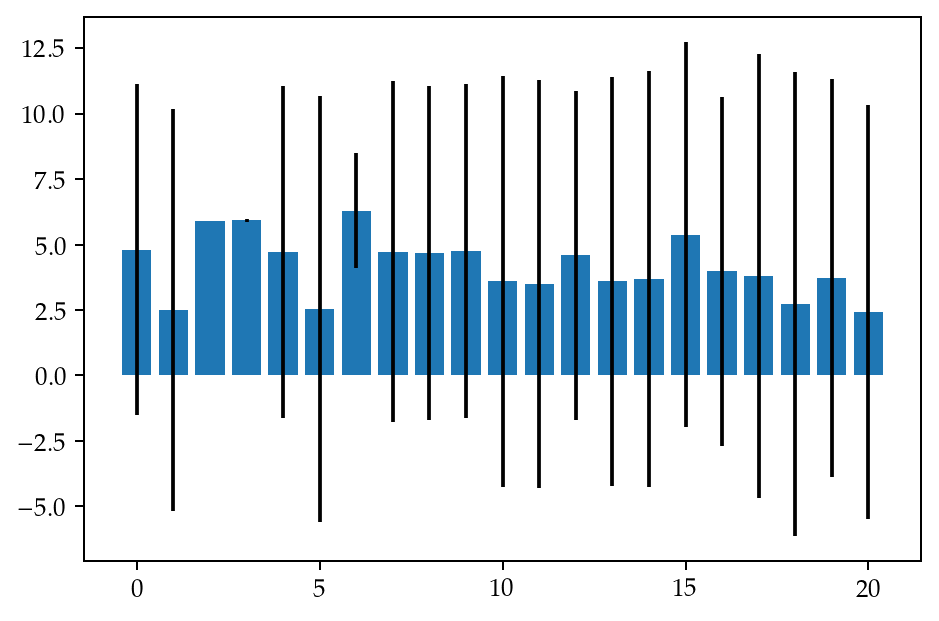

In [54]:
plt.bar(range(0, 21), means, yerr=a)